In [ ]:

from google.colab import drive
drive.mount('/content/drive')

import os

# Set the folder path = put whever the images are stored in your google drive
folder_path = '/content/drive/MyDrive/Colab Notebooks/faces/faces'


for person_folder in os.listdir(folder_path):
  person_path = os.path.join(folder_path, person_folder)


  for image_file in os.listdir(person_path):
    image_path = os.path.join(person_path, image_file)


    if "2" in image_file or "4" in image_file:
      continue
    elif image_file.endswith(".bad"):
      os.remove(image_path)
    else:
      os.remove(image_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


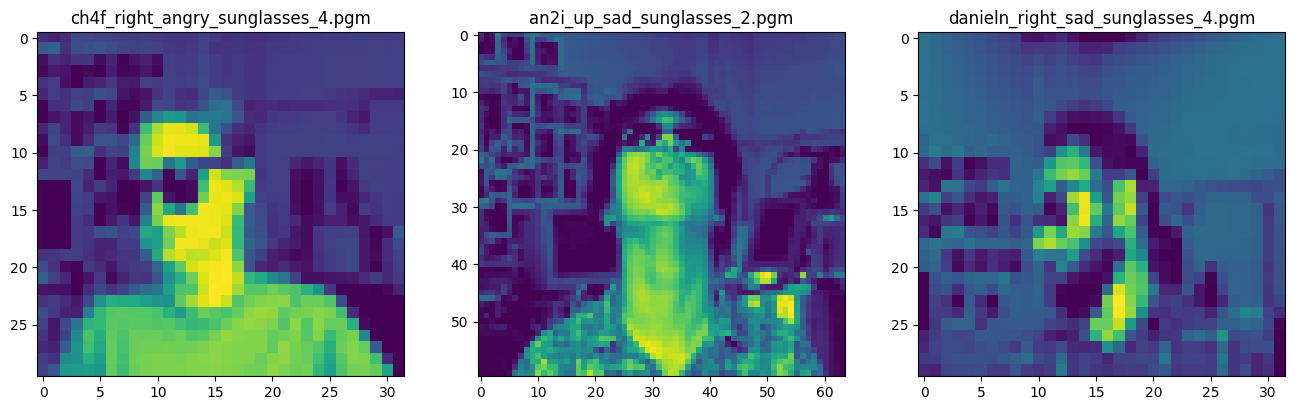

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(nrows=1, ncols = 3)
fig.subplots_adjust(left=.05, right=2)


for ax in axes:

    person_folder = np.random.choice(os.listdir(folder_path))
    person_path = os.path.join(folder_path, person_folder)
    pic = np.random.choice(os.listdir(person_path))
    pic_path = os.path.join(person_path, pic)


    image = Image.open(pic_path)


    ax.set_title(pic)
    ax.imshow(image)

In [ ]:
from sklearn.model_selection import train_test_split
label = []

train_x = []

image_type = "4"

for person_folder in os.listdir(folder_path):
    images = os.path.join(folder_path, person_folder)
    if os.path.isdir(images):
        for one_image in os.listdir(images):
            one_image_path = os.path.join(images, one_image)
            string = one_image_path.split("_")
            if image_type in string[-1]:
                train_x.append(np.asarray(Image.open(one_image_path)))
                label.append(string[1:4])

In [ ]:
#Divide train_x into sunglasses and no sunglasses subsets
sunglasses_x = []
glasses_label = []
no_glasses_x = []
no_label = []
for img, label in zip(train_x, label):
    if label[2] == "open":
        no_glasses_x.append(img)
        no_label.append(label[1])
    elif label[2] == "sunglasses":
        sunglasses_x.append(img)
        glasses_label.append(label[1])

In [ ]:
# categorically encode the picture labels using dictionary (happy, sad, neutral, angry)
dummies_dict = {
    "happy": [1, 0, 0, 0],
    "sad": [0, 1, 0, 0],
    "neutral": [0, 0, 1, 0],
    "angry": [0, 0, 0, 1]
}

#function to get dummy variables
def get_dummies(labels):
    dummy_labels = []
    for label in labels:
      dummy_labels.append(dummies_dict[label])
    return np.array(dummy_labels)

# Encode the labels for both the "sunglasses" and "open" datasets
y_glasses = get_dummies(glasses_label)
y_no = get_dummies(no_label)

In [ ]:
# final train test split
X_train_sunglasses, X_test_sunglasses, y_train_sunglasses, y_test_sunglasses = train_test_split(sunglasses_x, y_glasses, test_size=0.7)
X_train_no_glasses, X_test_no_glasses, y_train_no_glasses, y_test_no_glasses = train_test_split(no_glasses_x, y_no, test_size=0.7)

In [ ]:
# which data set will be given to the model
use_sunglasses = False # change this if you want to use data with sunglasses or not
batch_size = 64
epochs = 75

if use_sunglasses == True:
    y_train = y_train_sunglasses
    X_train = X_train_sunglasses
    y_test = y_test_sunglasses
    X_test = X_test_sunglasses

if use_sunglasses == False:
    y_train = y_train_no_glasses
    X_train = X_train_no_glasses
    y_test = y_test_no_glasses
    X_test = X_test_no_glasses

num_labels = 4

num_features = len(X_train[1])


if image_type == "2":
    height = 64
    width = 60

if image_type == "4":
    height = 32
    width = 30


In [ ]:
import keras
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Activation, Flatten

model = Sequential()


model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), padding='same', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(4*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(4*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(8*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(8*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(64*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(16*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))


#Compliling the model with adam optimixer and categorical crossentropy loss
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])

#training the model
model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_test), np.array(y_test)),
          shuffle=True)

Epoch 1/75
1/1 [==============================] - 3s 3s/step - loss: 2.3462 - accuracy: 0.1905 - val_loss: 1.4057 - val_accuracy: 0.2600
Epoch 2/75
1/1 [==============================] - 1s 740ms/step - loss: 2.4575 - accuracy: 0.1667 - val_loss: 1.4058 - val_accuracy: 0.2500
Epoch 3/75
1/1 [==============================] - 1s 646ms/step - loss: 2.3001 - accuracy: 0.2381 - val_loss: 1.4060 - val_accuracy: 0.2800
Epoch 4/75
1/1 [==============================] - 1s 735ms/step - loss: 2.3199 - accuracy: 0.2619 - val_loss: 1.4062 - val_accuracy: 0.3000
Epoch 5/75
1/1 [==============================] - 1s 728ms/step - loss: 2.2296 - accuracy: 0.2857 - val_loss: 1.4065 - val_accuracy: 0.3100
Epoch 6/75
1/1 [==============================] - 1s 744ms/step - loss: 1.6312 - accuracy: 0.4524 - val_loss: 1.4069 - val_accuracy: 0.3000
Epoch 7/75
1/1 [==============================] - 1s 752ms/step - loss: 2.3314 - accuracy: 0.1905 - val_loss: 1.4072 - val_accuracy: 0.2900
Epoch 8/75
1/1 [=======